In [2]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import os

def extract_features(model, folder_path):
    # Get a list of all image files in the folder
    img_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Use list comprehension to process images and extract features
    features = []
    for img_path in img_paths:
        try:
            img = image.load_img(img_path, target_size=model.input_shape[1:3])
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)
            feature = model.predict(img_array)
            features.append(feature)
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

    # Stack the extracted features into a single NumPy array
    features = np.vstack(features)

    return features

# Load the pre-trained VGG16 model with top (fully connected) layers
# base_model = ResNet50(weights='imagenet', include_top=True, input_shape=(224, 224, 3))  # Adjust input_shape accordingly
# 
# # Create a new model that includes only the convolutional base of VGG16
# model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_poool').output)

# Specify folder paths for emotion of child face image sets
angry_folder_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Data_set/Angry'
fear_folder_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Data_set/Fear'
joy_folder_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Data_set/Joy'
natural_folder_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Data_set/Natural'
sadness_folder_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Data_set/Sadness'
surprise_folder_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Data_set/Surprise'

# Load the pre-trained ResNet50 model with top (fully connected) layers
base_model = InceptionV3(weights='imagenet', include_top=True, input_shape=(299,299, 3)) # Adjust input_shape accordingly

# Create a new model that includes only the convolutional base of ResNet50
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

# Extract features for angry child faces
angry_features = extract_features(model, angry_folder_path)

# Extract features for fear child faces
fear_features = extract_features(model, fear_folder_path)

# Extract features for joy child faces
joy_features = extract_features(model, joy_folder_path)

# Extract features for natural child faces
natural_features = extract_features(model, natural_folder_path)

# Extract features for sadness child faces
sadness_features = extract_features(model, sadness_folder_path)

# Extract features for surprise child faces
surprise_features = extract_features(model, surprise_folder_path)

# Save the extracted features for later use in training
np.save('/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Feature_extraction/InceptionV3/angry/angry_features.npy', angry_features)
np.save('/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Feature_extraction/InceptionV3/fear/fear_features.npy', fear_features)
np.save('/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Feature_extraction/InceptionV3/joy/joy_features.npy', joy_features)
np.save('/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Feature_extraction/InceptionV3/natural/natural_features.npy', natural_features)
np.save('/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Feature_extraction/InceptionV3/sadness/sadness_features.npy', sadness_features)
np.save('/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Feature_extraction/InceptionV3/surprise/surprise_features.npy', surprise_features)

2024-03-08 08:01:19.760659: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 53ms/step


In [3]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

# Load features and labels
angry_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Feature_extraction/InceptionV3/angry/angry_features.npy')
fear_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Feature_extraction/InceptionV3/fear/fear_features.npy')
joy_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Feature_extraction/InceptionV3/joy/joy_features.npy')
natural_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Feature_extraction/InceptionV3/natural/natural_features.npy')
sadness_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Feature_extraction/InceptionV3/sadness/sadness_features.npy')
surprise_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Feature_extraction/InceptionV3/surprise/surprise_features.npy')

# Create labels
angry_labels = np.ones(angry_features.shape[0]) * 0
fear_labels = np.ones(fear_features.shape[0]) * 1
joy_labels = np.ones(joy_features.shape[0]) * 2
natural_labels = np.ones(natural_features.shape[0]) * 3
sadness_labels = np.ones(sadness_features.shape[0]) * 4
surprise_labels = np.ones(surprise_features.shape[0]) * 5

# Combine features and labels
X = np.vstack([angry_features, fear_features, joy_features, natural_features, sadness_features, surprise_features])
y = np.concatenate([angry_labels, fear_labels, joy_labels, natural_labels, sadness_labels, surprise_labels])

# Shuffle the data
X, y = shuffle(X, y, random_state=42)

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=6)
y_test_encoded = to_categorical(y_test, num_classes=6)

# Model definition
model = Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))  # Input shape based on extracted features
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))  # Assuming 6 emotions

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model training
model.fit(X_train, y_train_encoded, epochs=100, batch_size=32, validation_split=0.2)

# Save the trained model to a file named 'emotion_model.h5'
model.save('/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Feature_extraction/InceptionV3/emotion_model.h5')

# Model evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy: {test_accuracy}')



Epoch 1/100
13/13 [==============================] - 0s 8ms/step - loss: 0.4612 - accuracy: 0.4524 - val_loss: 0.3484 - val_accuracy: 0.5204
Epoch 2/100
13/13 [==============================] - 0s 4ms/step - loss: 0.3625 - accuracy: 0.5193 - val_loss: 0.3335 - val_accuracy: 0.5612
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 0.3420 - accuracy: 0.5681 - val_loss: 0.3241 - val_accuracy: 0.6224
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 0.3270 - accuracy: 0.6041 - val_loss: 0.3191 - val_accuracy: 0.6224
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 0.3174 - accuracy: 0.6118 - val_loss: 0.3221 - val_accuracy: 0.6327
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 0.3015 - accuracy: 0.6144 - val_loss: 0.3030 - val_accuracy: 0.6122
Epoch 7/100
13/13 [==============================] - 0s 4ms/step - loss: 0.2888 - accuracy: 0.6144 - val_loss: 0.3128 - val_accuracy: 0.6429
Epoch 8/100
1

2024-03-09 13:57:13.779090: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 1s 985ms/step
Predicted emotion: Angry
Prediction probability: 0.00


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 600ms/step


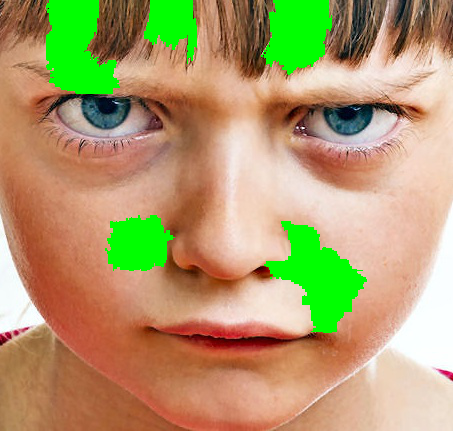

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from skimage.segmentation import mark_boundaries
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense
from PIL import Image
from pathlib import Path
from IPython.display import display
from lime.lime_image import LimeImageExplainer

# Provide the path to your image file
image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Data_set/Angry/0281.jpg'  # Replace with your image path

# target_size = (224, 224)

# Check if the file exists
if Path(image_path).is_file():
    model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Feature_extraction/InceptionV3/emotion_model.h5'
    target_size = (299, 299)

    # Load the pre-trained VGG16 model with top layers included
    base_model = InceptionV3(weights='imagenet', include_top=True)

    # Take the output of the base model up to the last convolutional layer
    x = base_model.get_layer('avg_pool').output

    # Add a new dense layer for output
    x = Dense(2048, activation='relu')(x)
    x = Reshape((1, 1, 2048))(x)
    x = GlobalAveragePooling2D()(x)

    predictions = Dense(1, activation='sigmoid')(x)

    # Create a new model that takes the input of VGG16 and outputs the desired layer
    model = Model(inputs=base_model.input, outputs=predictions)

    # Process the input image
    img = np.array(Image.open(image_path).resize(target_size))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR
    img = np.expand_dims(img, axis=0)  # Add a batch dimension
    img = preprocess_input(img)  # Preprocess the image

    # Preprocess the image for the explainer by dividing pixel values by 255
    img_scaled = img / 255.0

    # Predict ASD probability using the full VGG16 model
    prediction = model.predict(img)  # Access the first element for ASD probability

    emotion_labels = ['Angry', 'Fear', 'Joy', 'Natural', 'Sadness', 'Surprise']
    predicted_emotion_index = np.argmax(prediction)
    predicted_emotion = emotion_labels[predicted_emotion_index]
    prediction_probability = prediction[0][predicted_emotion_index]

    print(f"Predicted emotion: {predicted_emotion}")
    print(f"Prediction probability: {prediction_probability:.2f}")

    explainer = LimeImageExplainer()

    # Generate an explanation for the prediction using the explainer object
    explanation = explainer.explain_instance(img_scaled[0], model.predict, top_labels=1, hide_color=0, num_samples=10000, random_seed=42)

    # Visualize the explanation using matplotlib
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

    # Resize the explanation mask to match the original image dimensions
    mask = cv2.resize(mask, (target_size[0], target_size[1]), interpolation=cv2.INTER_NEAREST)

    # Convert the mask to the original image mode
    original_image = Image.open(image_path)
    #original_image = original_image.convert("L")  # Convert the original image to grayscale
    original_width, original_height = original_image.size
    original_mode = original_image.mode

    # Overlay the explanation mask on the original image
    mask = cv2.resize(mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)
    original_image = np.array(original_image)
    original_image[mask > 0.5] = (0, 255, 0)

    display(Image.fromarray(original_image))


else:
    print("Error: Image file not found.")

1/1 [==============================] - 0s 23ms/step
Predicted emotion: Angry
Prediction probability: 0.61


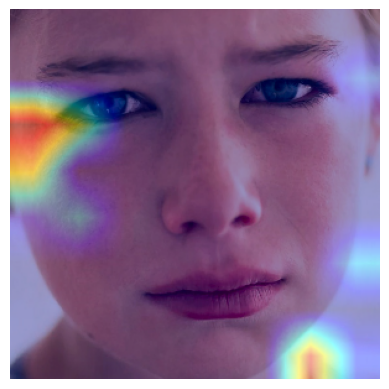

In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
import tensorflow as tf

# Define Grad-CAM function
def generate_grad_cam(model, img_array, layer_name):
    # Create a model that maps the input image to the desired layer's output
    grad_model = Model(inputs=model.input, outputs=(model.get_layer(layer_name).output, model.output))

    # Compute the gradient of the predicted class with respect to the output feature map of the given layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        predicted_class_output = preds[:, 0]  # Assuming ASD class is the first one

    grads = tape.gradient(predicted_class_output, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]

    # Compute the heatmap
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU on the heatmap
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap

# Define paths
input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Data_set/Angry/0283.jpg'  # Replace with your image path
model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/EMOTION/Feature_extraction/InceptionV3/emotion_model.h5'
target_size = (299, 299)

# Load the pre-trained VGG16 model with top layers included
base_model = InceptionV3(weights='imagenet', include_top=True)

# Create a new model that takes the input of VGG16 and outputs the desired layer/
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

# Process the input image
img_original = cv2.imread(input_image_path)
img_original = cv2.resize(img_original, target_size)
img_for_model = preprocess_input(np.expand_dims(img_original, axis=0))

# Extract features using the full VGG16 model
features = model.predict(img_for_model)  # Use the new model

# Reshape features to match the expected input shape of trained_model
features_reshaped = np.reshape(features, (1, 2048 ))# Reshape to (None, 14, 14, 512)

# Load the trained model
trained_model = load_model(model_path)

# Make predictions using the loaded model
prediction = trained_model.predict(features_reshaped)

emotion_labels = ['Angry', 'Fear', 'Joy', 'Natural', 'Sadness', 'Surprise']
predicted_emotion_index = np.argmax(prediction)
predicted_emotion = emotion_labels[predicted_emotion_index]
prediction_probability = prediction[0][predicted_emotion_index]

print(f"Predicted emotion: {predicted_emotion}")
print(f"Prediction probability: {prediction_probability:.2f}")

# Visualize the Grad-CAM heatmap
heatmap = generate_grad_cam(model, img_for_model, 'mixed10')

# Resize heatmap to match the size of the original image
heatmap = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))

# Apply colormap for better visualization
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(img_original, 0.6, heatmap, 0.4, 0)

# Display the superimposed image
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
